In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#import libraries and some constants

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
import pandas as pd
import uproot as ur
import pickle
from pathlib import Path
import atlas_mpl_style as ampl
ampl.use_atlas_style()

path_prefix = '/AL/Phd/maxml/caloml-atlas/'
plotpath = path_prefix+'classifier/Plots_dset/'
modelpath = path_prefix+'classifier/Models/'

# import our resolution utilities
import sys
sys.path.append(path_prefix)
from  util import resolution_util as ru
from  util import plot_util as pu
from  util import ml_util as mu

Using TensorFlow backend.


In [3]:
import numpy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import Convolution3D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import MaxPool3D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow import keras as keras

import tensorflow as tf
from sklearn.metrics import roc_curve, auc

gpu_list = ["/gpu:0"]
strategy = tf.distribute.MirroredStrategy(devices=gpu_list)
# strategy = tf.distribute.MirroredStrategy()
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [4]:
def cnn_model_baseline():
    with strategy.scope():
        input1 = Input(shape=(6, 16, 16), name='input1')
        x = Convolution2D(32, (2,2), activation='relu', data_format = 'channels_first')(input1)
        x = MaxPool2D(pool_size=(2, 2))(x)
        x = Dropout(0.2)(x)
        x = Flatten()(x)
        x = Dense(128, activation='relu')(x)
        x = Dense(64, activation='relu')(x)
        output = Dense(2, activation='softmax')(x)
        model = Model(inputs = [input1], outputs = [output])
        
        # compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
        return model

In [5]:
inputpath = path_prefix+'inputs/'
rootfiles = ["pi0", "piplus", "piminus"]
training_classes = ['pi0','piplus']
cell_shapes = {
    'EMB1': (128,4),
    'EMB2': (16,16),
    'EMB3': (8,16),
    'TileBar0': (4,4),
    'TileBar1': (4,4),
    'TileBar2': (2,4),
}

# fancy display names for each pion type
pi_latex = {
    'pi0': '\(\pi^{0}\)',
    'piplus': '\(\pi^{+}\)',
    'piminus': '\(\pi^{-}\)',
}

def test_dataset(dataset,filename='',
                 epochs=100, average=False):
    if( filename == '' ):
        filename = dataset

    trees, pdata = mu.setupPionData(inputpath+dataset+'_', rootfiles)
    
#     np0 = len(pdata['pi0'])
#     npp = len(pdata['piplus'])
#     npm = len(pdata['piminus'])

#     print("Number of pi0 events: {}".format(np0))
#     print("Number of pi+ events: {}".format(npp))
#     print("Number of pi- events: {}".format(npm))
#     print("Total: {}".format(np0+npp+npm))

    pcells = {
        ifile : {
            layer : mu.setupCells(itree, layer, flatten = False)
            for layer in mu.cell_meta
        }
        for ifile, itree in trees.items()
    }
    
    if(average):
        layer_average = {}
        for ptype in pcells:
            layer_average[ptype] = {}
            for layer in mu.cell_meta:
                plt.cla(); plt.clf()
                fig = plt.figure()
                fig.patch.set_facecolor('white')
                layer_average[ptype][layer] = pcells[ptype][layer].sum(axis=0).reshape(cell_shapes[layer]) / len(pcells[ptype][layer])
                plt.imshow(layer_average[ptype][layer], extent=[-0.2, 0.2, -0.2, 0.2],
                           cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest')
        #         plt.title('Average '+ptype+' event in '+layer+', '+label)
                ampl.set_xlabel("$\Delta\phi$")
                ampl.set_ylabel("$\Delta\eta$")
                ampl.draw_atlas_label(0.05, 0.95, simulation = True, fontsize = 18)
                fig.axes[0].text(-0.18, 0.135, 'Average '+pi_latex[ptype]+' event in '+layer)
                fig.axes[0].text(-0.18, 0.105, dataset.replace('_','-'))
                cbar = plt.colorbar()
                cbar.set_label('Energy fraction', rotation=270, labelpad=20)
                plt.savefig(plotpath+dataset+'_'+ptype+'_'+layer+'.pdf')
                plt.show()
        return layer_average

    # create train/validation/test subsets containing 70%/10%/20%
    # of events from each type of pion event
    pdata_merged, pcells_merged, plabels = mu.createTrainingDatasets(training_classes, pdata, pcells)

    pcells_merged_reshaped = mu.reshapeSeparateCNN(pcells_merged)
    pcells_EMB2_channels = mu.setupChannelImages(mu.rescaleImages(pcells_merged, (16, 16)))
    
    # check if model has been trained already
    if Path(modelpath+filename+'.h5').is_file():
        # load model
        model = tf.keras.models.load_model(modelpath+filename+".h5")
    else:
        # train model
        model = cnn_model_baseline()
        f_history = model.fit(pcells_EMB2_channels[pdata_merged.train],
                            plabels[pdata_merged.train], 
                            validation_data=(pcells_EMB2_channels[pdata_merged.val],
                                             plabels[pdata_merged.val]),
                            epochs=epochs, batch_size=200*ngpu, verbose=2)
        f_history = f_history.history

        # save trained weights and history
        if(filename != ''):
            model.save(modelpath+filename+".h5")
            with open(modelpath+filename +".history",'wb') as model_history_file:
                pickle.dump(f_history, model_history_file)
            
    # get network scores for the dataset
    f_score = model.predict(
        pcells_EMB2_channels
    )
    
    # calculate roc and auc
    f_roc_fpr, f_roc_tpr, f_roc_thresh = roc_curve(
        plabels[pdata_merged.test][:,1],
        f_score[pdata_merged.test,1],
        drop_intermediate=False,
    )
    f_roc_auc = auc(f_roc_fpr, f_roc_tpr)
    return f_roc_fpr, f_roc_tpr, f_roc_auc

<Figure size 576x432 with 0 Axes>

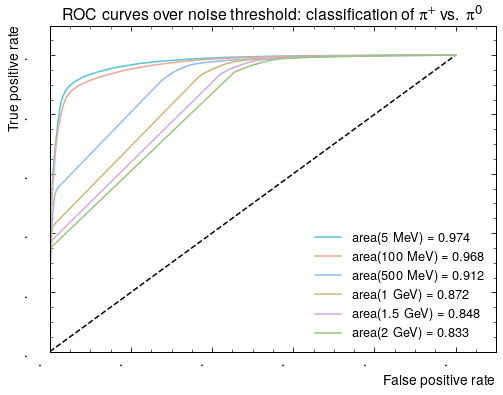

In [19]:
# dsets = ['nthresh_0','nthresh_2','nthresh_5','nthresh_10','nthresh_norm','nthresh_none']
# tvals = ['0 MeV','2 MeV','5 MeV','10 MeV','norm','none']
dsets = ['nthresh_5', 'nthresh_100', 'nthresh_500', 'nthresh_1000', 'nthresh_1500', 'nthresh_2000']
tvals = ['5 MeV', '100 MeV', '500 MeV', '1 GeV', '1.5 GeV', '2 GeV']
nthresh_fpr = []
nthresh_tpr = []
nthresh_auc = []
averages = {}
for ds in dsets:
#     averages[ds] = test_dataset(ds)
    fpr, tpr, auc_val = test_dataset(ds, epochs=20)
    nthresh_fpr.append(fpr)
    nthresh_tpr.append(tpr)
    nthresh_auc.append(auc_val)
    
pu.roc_plot(nthresh_fpr, nthresh_tpr,
            figfile=plotpath+'nthresh_high_roc.pdf',
            labels=['area({}) = {:.3f}'.format(t,auc) for t,auc in zip(tvals,nthresh_auc)],
            extra_lines=[[[0, 1], [0, 1]]],
            title='ROC curves over noise threshold: classification of $\pi^+$ vs. $\pi^0$')

<Figure size 576x432 with 0 Axes>

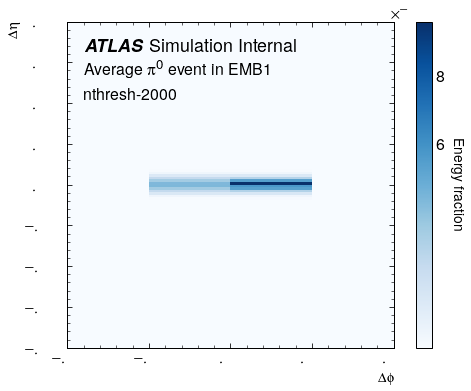

<Figure size 576x432 with 0 Axes>

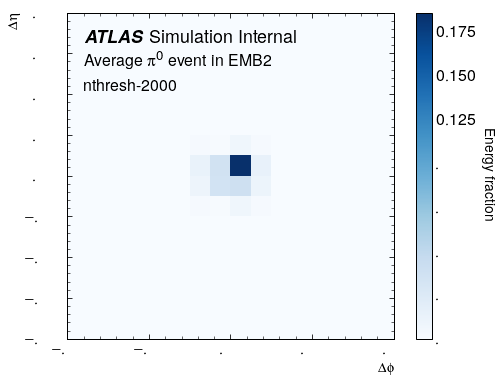

<Figure size 576x432 with 0 Axes>

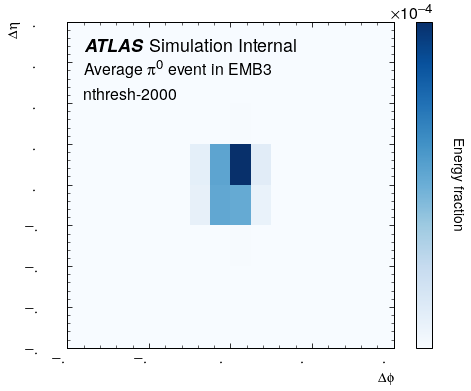

<Figure size 576x432 with 0 Axes>

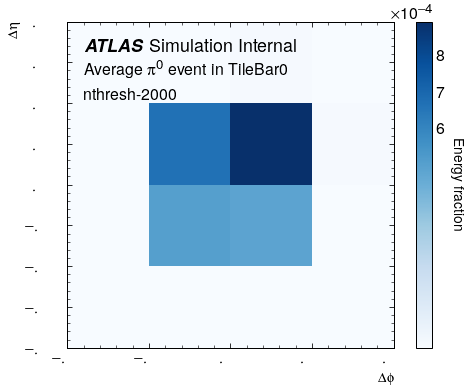

<Figure size 576x432 with 0 Axes>

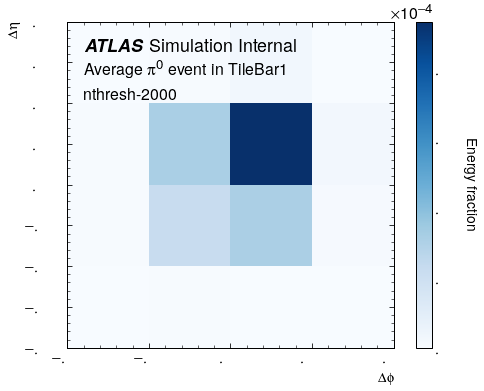

<Figure size 576x432 with 0 Axes>

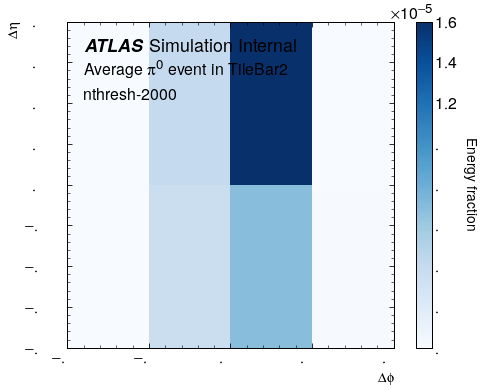

<Figure size 576x432 with 0 Axes>

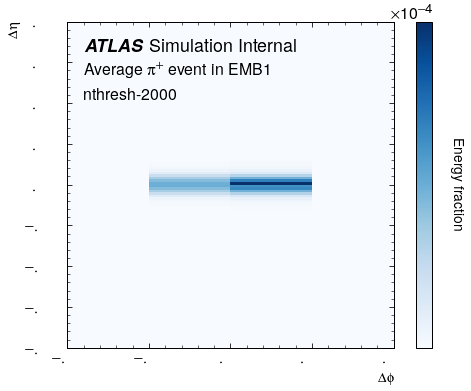

<Figure size 576x432 with 0 Axes>

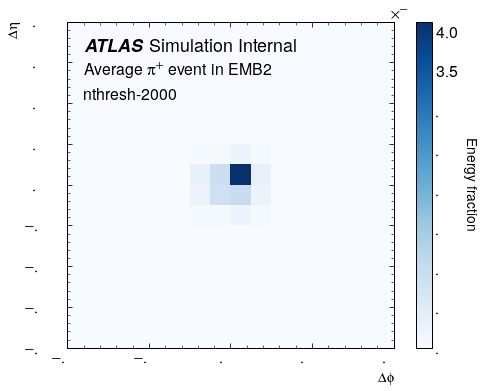

<Figure size 576x432 with 0 Axes>

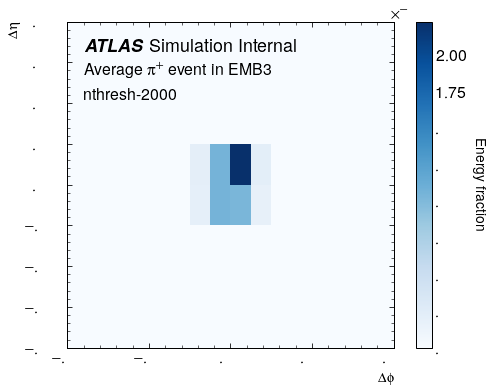

<Figure size 576x432 with 0 Axes>

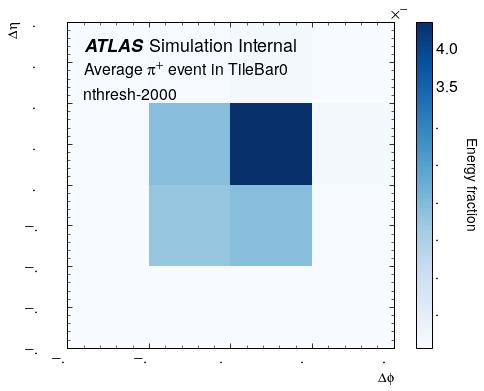

<Figure size 576x432 with 0 Axes>

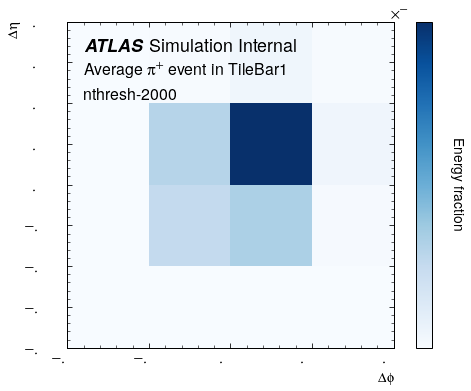

<Figure size 576x432 with 0 Axes>

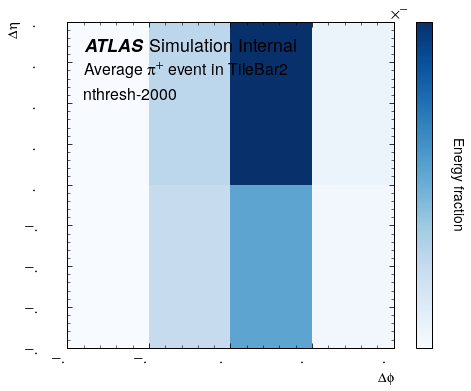

<Figure size 576x432 with 0 Axes>

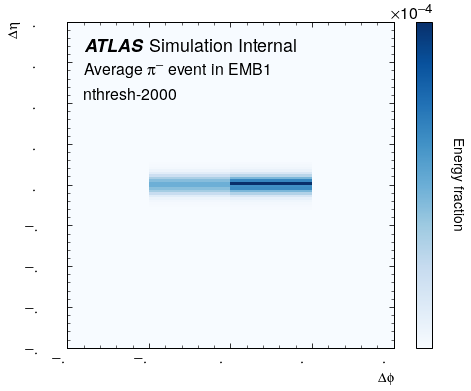

<Figure size 576x432 with 0 Axes>

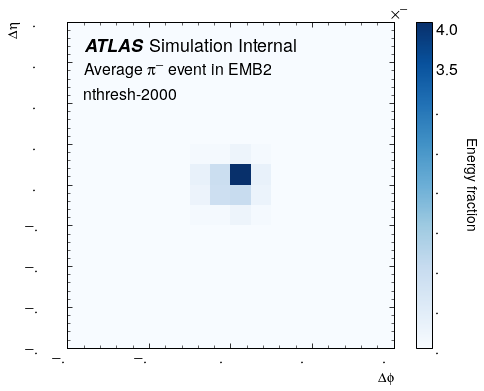

<Figure size 576x432 with 0 Axes>

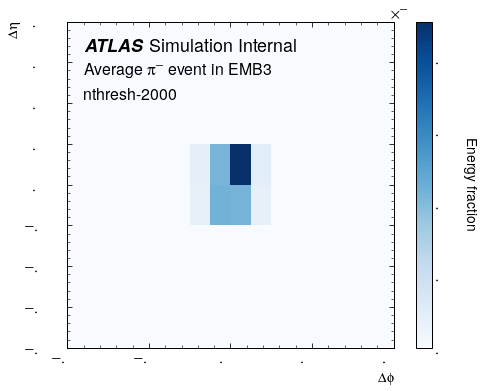

<Figure size 576x432 with 0 Axes>

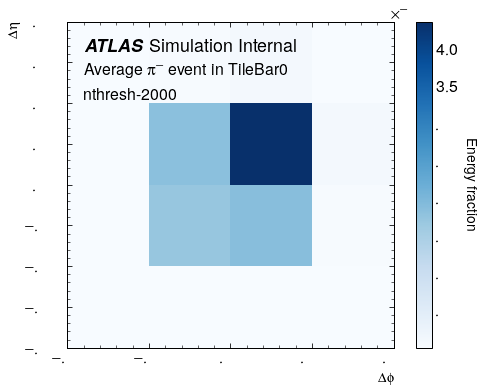

<Figure size 576x432 with 0 Axes>

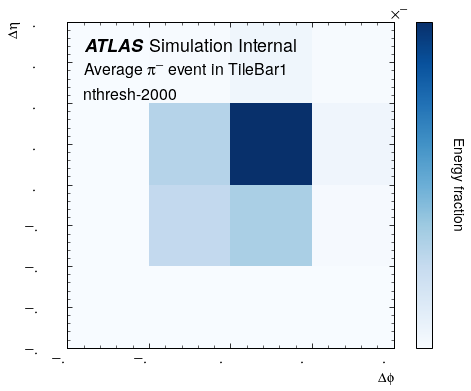

<Figure size 576x432 with 0 Axes>

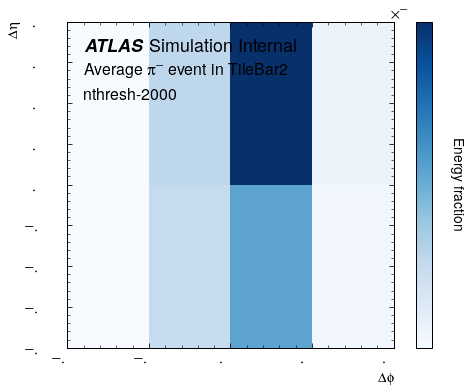

In [34]:
averages['nthresh_2000'] = ( test_dataset('nthresh_2000', epochs=20, average=True) )

In [35]:
layer_diff = {}
for ds in dsets:
    for ptype in rootfiles:
        layer_diff[ptype] = {}
        for layer in mu.cell_meta:
                    plt.cla(); plt.clf()
                    fig = plt.figure()
                    fig.patch.set_facecolor('white')
                    layer_diff[ptype][layer] = averages['nthresh_5'][ptype][layer] - averages[ds][ptype][layer]
                    plt.imshow(layer_diff[ptype][layer], extent=[-0.2, 0.2, -0.2, 0.2],
    #                            norm=mpl.colors.SymLogNorm(linthresh=0.002, linscale=1,
    #                            vmin=-1.0, vmax=1.0, base=10),cmap='RdBu'
                               cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest')
            #         plt.title('Average '+ptype+' event in '+layer+', '+label)
                    ampl.set_xlabel("$\Delta\phi$")
                    ampl.set_ylabel("$\Delta\eta$")
                    ampl.draw_atlas_label(0.05, 0.95, simulation = True, fontsize = 18)
                    fig.axes[0].text(-0.18, 0.135, 'Average '+pi_latex[ptype]+' event in '+layer)
                    fig.axes[0].text(-0.18, 0.105, 'nthresh5 - '+ds.replace('_',''))
                    cbar = plt.colorbar()
                    cbar.set_label('Energy fraction', rotation=270, labelpad=20)
                    plt.savefig(plotpath+'diff_5_'+ds+'_'+ptype+'_'+layer+'.pdf')
                    plt.show()

KeyError: 'nthresh_5'

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

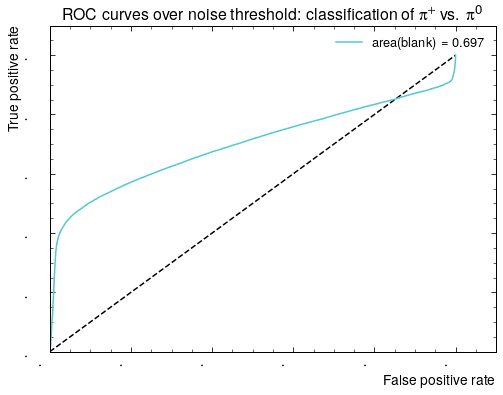

In [11]:
# 'blank' cell test
trees, pdata = mu.setupPionData(inputpath+'nthresh_5'+'_', rootfiles)

pcells = {
    ifile : {
        layer : mu.setupCells(itree, layer, flatten = False)
        for layer in mu.cell_meta
    }
    for ifile, itree in trees.items()
}

# create train/validation/test subsets containing 70%/10%/20%
# of events from each type of pion event
pdata_merged, pcells_merged, plabels = mu.createTrainingDatasets(training_classes, pdata, pcells)

pcells_merged_reshaped = mu.reshapeSeparateCNN(pcells_merged)
pcells_blank = np.zeros((701116, 6, 16, 16))
pcells_EMB2_channels = mu.setupChannelImages(mu.rescaleImages(pcells_merged, (16, 16)))

# check if model has been trained already
if Path(modelpath+'blank'+'.h5').is_file():
    # load model
    model = tf.keras.models.load_model(modelpath+'blank'+".h5")
else:
    # train model
    model = cnn_model_baseline()
    f_history = model.fit(pcells_blank[pdata_merged.train],
                        plabels[pdata_merged.train], 
                        validation_data=(pcells_EMB2_channels[pdata_merged.val],
                                         plabels[pdata_merged.val]),
                        epochs=20, batch_size=200*ngpu, verbose=2)
    f_history = f_history.history

    # save trained weights and history
    model.save(modelpath+'blank'+".h5")
    with open(modelpath+'blank' +".history",'wb') as model_history_file:
        pickle.dump(f_history, model_history_file)

# get network scores for the dataset
f_score = model.predict(
    pcells_EMB2_channels
)

# calculate roc and auc
f_roc_fpr, f_roc_tpr, f_roc_thresh = roc_curve(
    plabels[pdata_merged.test][:,1],
    f_score[pdata_merged.test,1],
    drop_intermediate=False,
)
f_roc_auc = auc(f_roc_fpr, f_roc_tpr)
pu.roc_plot([f_roc_fpr], [f_roc_tpr],
            figfile=plotpath+'blank_roc.pdf',
            labels=['area({}) = {:.3f}'.format('blank',f_roc_auc)],
            extra_lines=[[[0, 1], [0, 1]]],
            title='ROC curves over noise threshold: classification of $\pi^+$ vs. $\pi^0$')


In [6]:
trees, pdata = mu.setupPionData(inputpath+'nthresh_2000'+'_', rootfiles)

pcells = {
    ifile : {
        layer : mu.setupCells(itree, layer, flatten = False)
        for layer in mu.cell_meta
    }
    for ifile, itree in trees.items()
}


In [6]:
# create train/validation/test subsets containing 70%/10%/20%
# of events from each type of pion event
pdata_merged, pcells_merged, plabels = mu.createTrainingDatasets(training_classes, pdata, pcells)

pcells_merged_reshaped = mu.reshapeSeparateCNN(pcells_merged)
pcells_blank = np.zeros((701116, 6, 16, 16))
pcells_EMB2_channels = mu.setupChannelImages(mu.rescaleImages(pcells_merged, (16, 16)))

# check if model has been trained already
if Path(modelpath+'blank'+'.h5').is_file():
    # load model
    model = tf.keras.models.load_model(modelpath+'blank'+".h5")
else:
    # train model
    model = cnn_model_baseline()
    f_history = model.fit(pcells_blank[pdata_merged.train],
                        plabels[pdata_merged.train], 
                        validation_data=(pcells_EMB2_channels[pdata_merged.val],
                                         plabels[pdata_merged.val]),
                        epochs=20, batch_size=200*ngpu, verbose=2)
    f_history = f_history.history

    # save trained weights and history
    model.save(modelpath+'blank'+".h5")
    with open(modelpath+'blank' +".history",'wb') as model_history_file:
        pickle.dump(f_history, model_history_file)

# get network scores for the dataset
f_score = model.predict(
    pcells_EMB2_channels
)

# calculate roc and auc
f_roc_fpr, f_roc_tpr, f_roc_thresh = roc_curve(
    plabels[pdata_merged.test][:,1],
    f_score[pdata_merged.test,1],
    drop_intermediate=False,
)
f_roc_auc = auc(f_roc_fpr, f_roc_tpr)
pu.roc_plot([f_roc_fpr], [f_roc_tpr],
            figfile=plotpath+'blank_roc.pdf',
            labels=['area({}) = {:.3f}'.format('blank',f_roc_auc)],
            extra_lines=[[[0, 1], [0, 1]]],
            title='ROC curves over noise threshold: classification of $\pi^+$ vs. $\pi^0$')

NameError: name 'pdata' is not defined

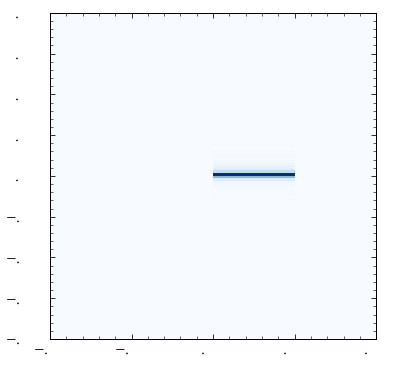

In [44]:
plt.imshow(pcells['pi0']['EMB1'][10], extent=[-0.2, 0.2, -0.2, 0.2],
                           cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest')

<Figure size 576x432 with 0 Axes>

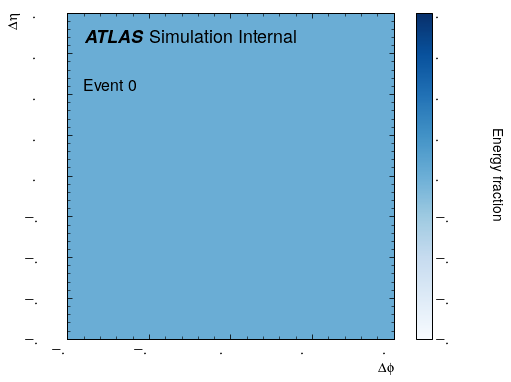

<Figure size 576x432 with 0 Axes>

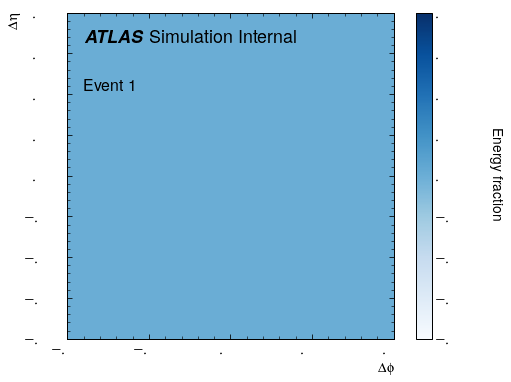

<Figure size 576x432 with 0 Axes>

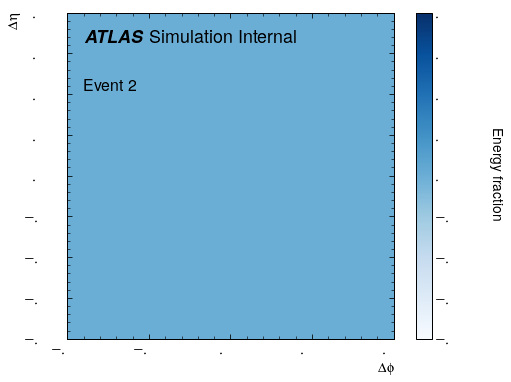

<Figure size 576x432 with 0 Axes>

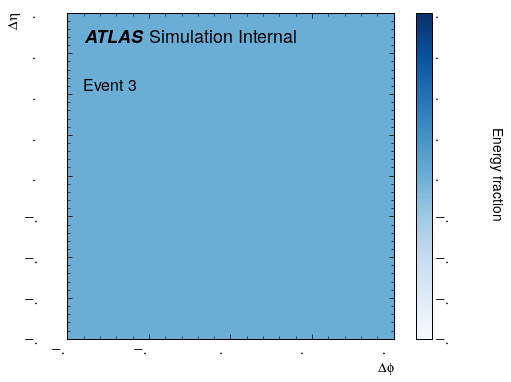

<Figure size 576x432 with 0 Axes>

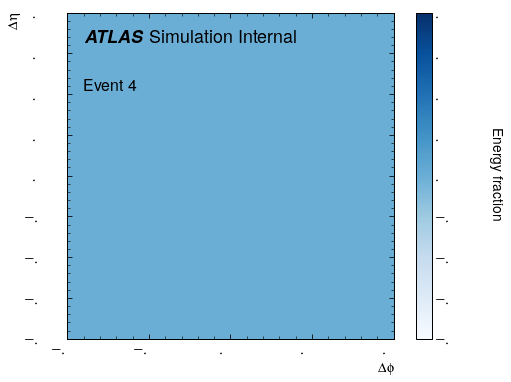

<Figure size 576x432 with 0 Axes>

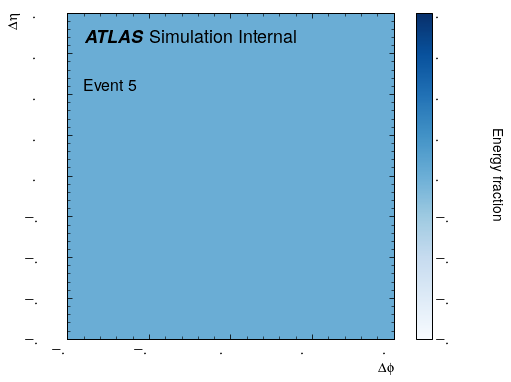

<Figure size 576x432 with 0 Axes>

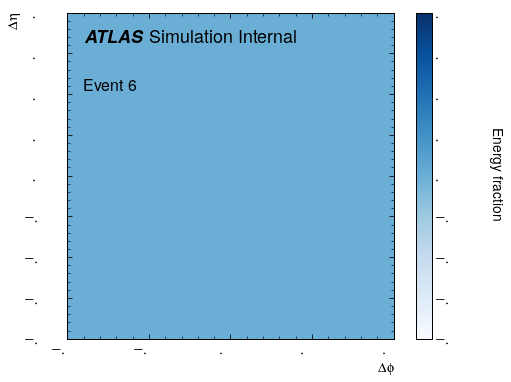

<Figure size 576x432 with 0 Axes>

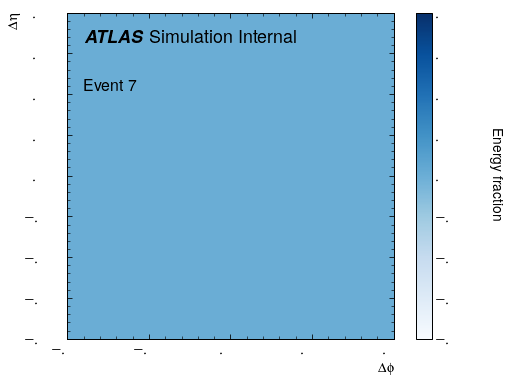

<Figure size 576x432 with 0 Axes>

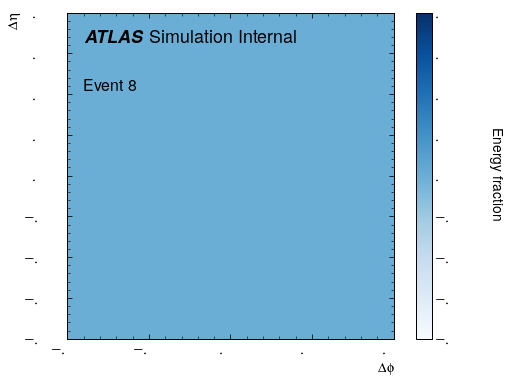

<Figure size 576x432 with 0 Axes>

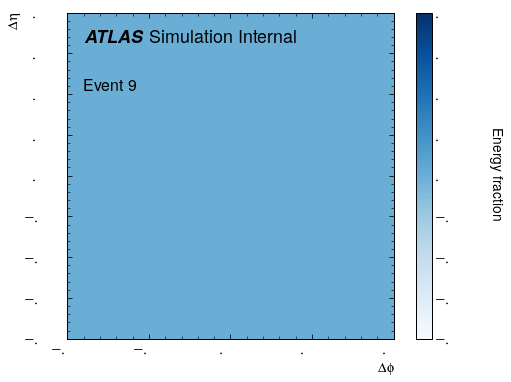

<Figure size 576x432 with 0 Axes>

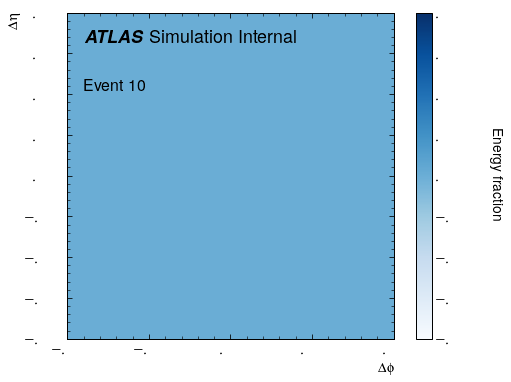

<Figure size 576x432 with 0 Axes>

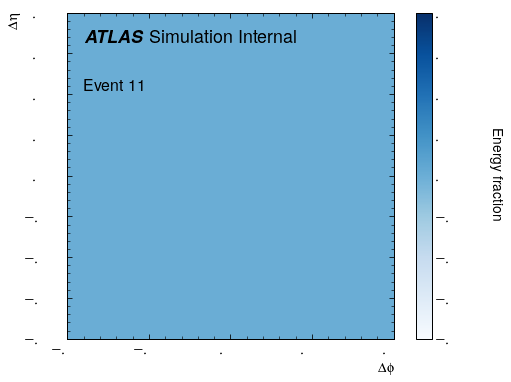

<Figure size 576x432 with 0 Axes>

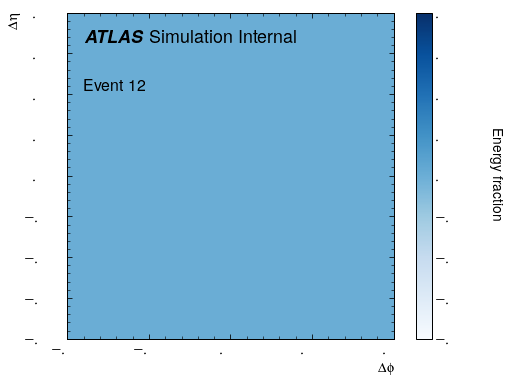

<Figure size 576x432 with 0 Axes>

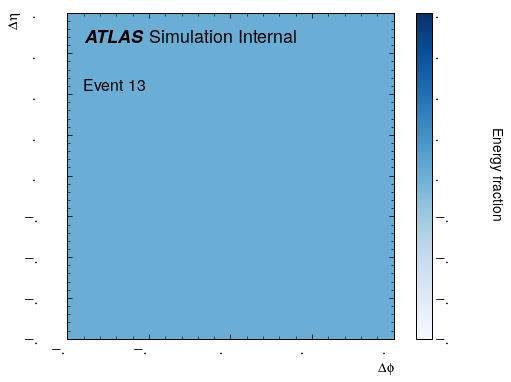

<Figure size 576x432 with 0 Axes>

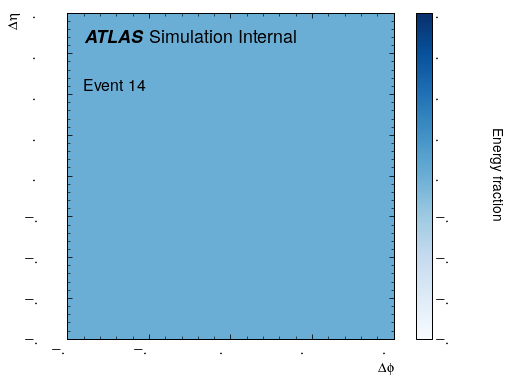

<Figure size 576x432 with 0 Axes>

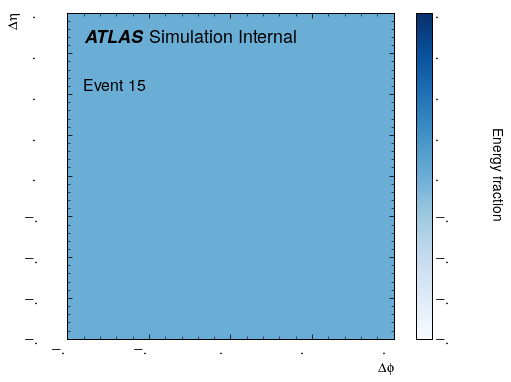

<Figure size 576x432 with 0 Axes>

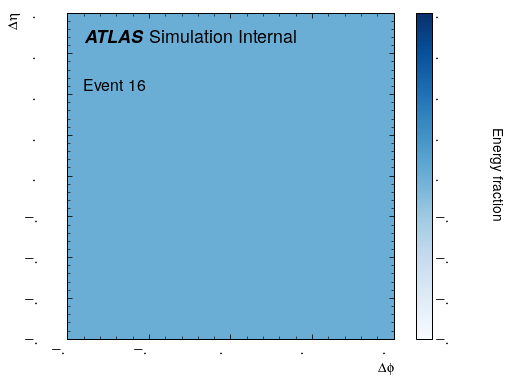

<Figure size 576x432 with 0 Axes>

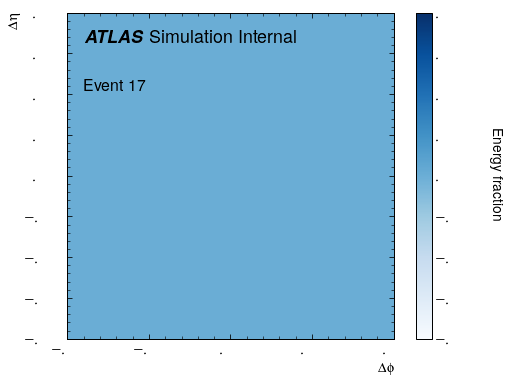

<Figure size 576x432 with 0 Axes>

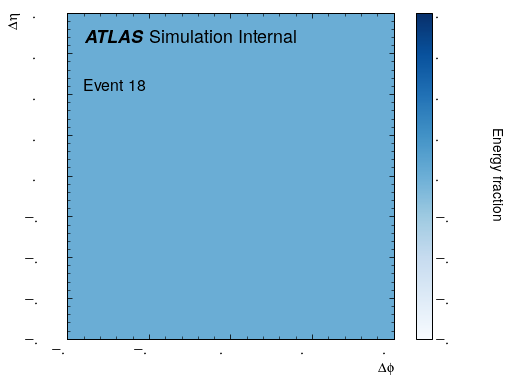

<Figure size 576x432 with 0 Axes>

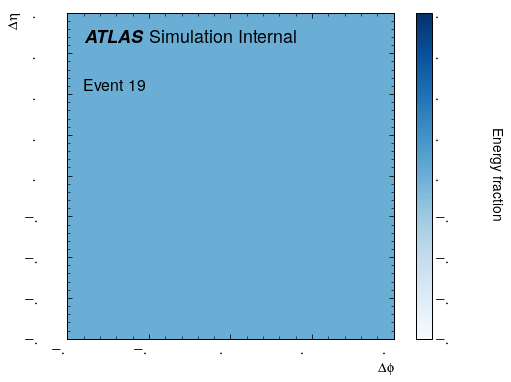

In [16]:
for i in range(20):
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.imshow(pcells['pi0']['TileBar2'][i], extent=[-0.2, 0.2, -0.2, 0.2],
               cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest')
    ampl.set_xlabel("$\Delta\phi$")
    ampl.set_ylabel("$\Delta\eta$")
    ampl.draw_atlas_label(0.05, 0.95, simulation = True, fontsize = 18)
#     fig.axes[0].text(-0.18, 0.135, 'Average '+pi_latex[ptype]+' event in '+layer)
    fig.axes[0].text(-0.18, 0.105, 'Event '+str(i))
    cbar = plt.colorbar()
    cbar.set_label('Energy fraction', rotation=270, labelpad=20)
    plt.savefig(plotpath+'individual/'+'nthresh_2000'+'_evt'+str(i)+'.pdf')
    plt.show()

<Figure size 576x432 with 0 Axes>

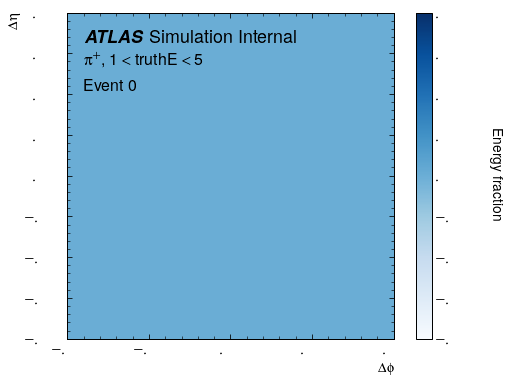

<Figure size 576x432 with 0 Axes>

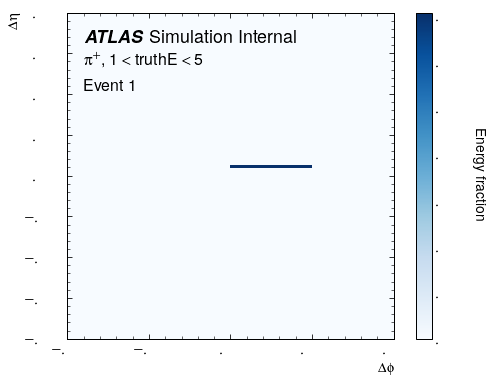

<Figure size 576x432 with 0 Axes>

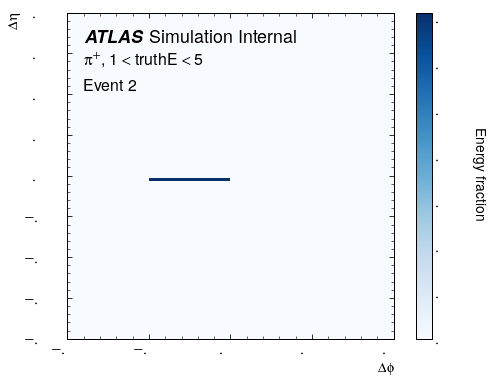

<Figure size 576x432 with 0 Axes>

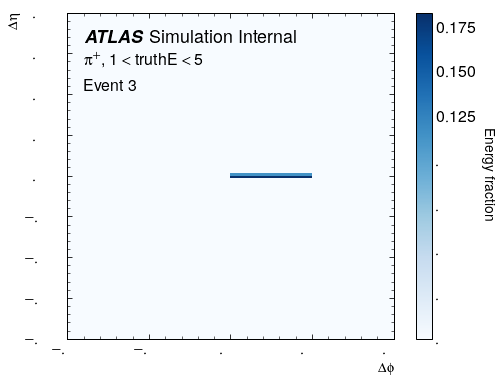

<Figure size 576x432 with 0 Axes>

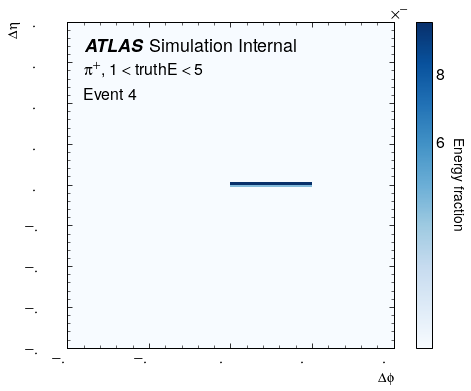

<Figure size 576x432 with 0 Axes>

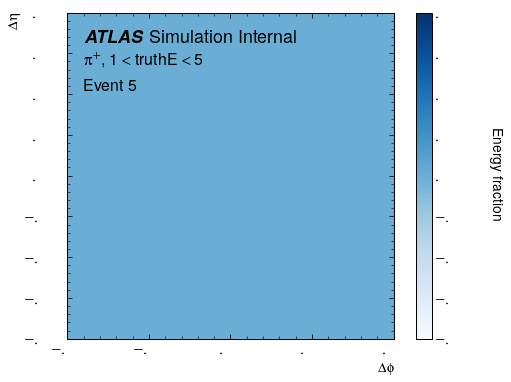

<Figure size 576x432 with 0 Axes>

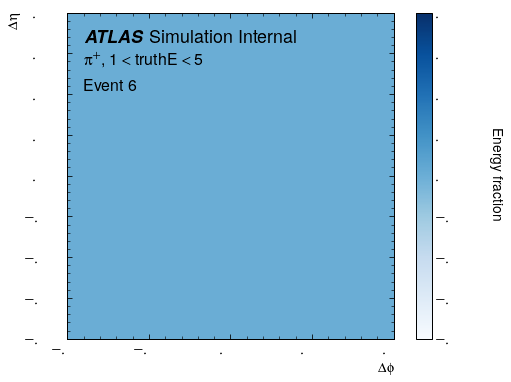

<Figure size 576x432 with 0 Axes>

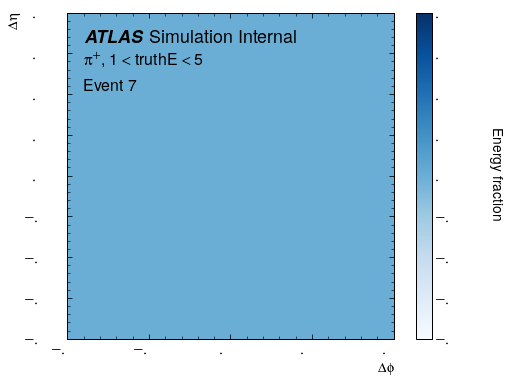

<Figure size 576x432 with 0 Axes>

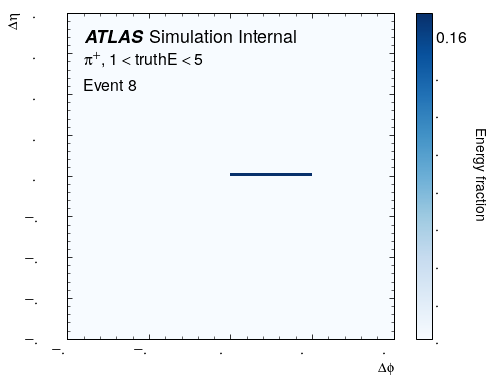

<Figure size 576x432 with 0 Axes>

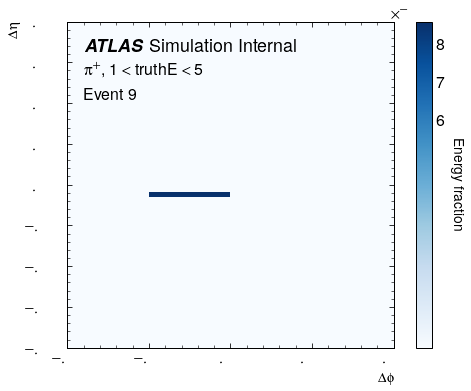

<Figure size 576x432 with 0 Axes>

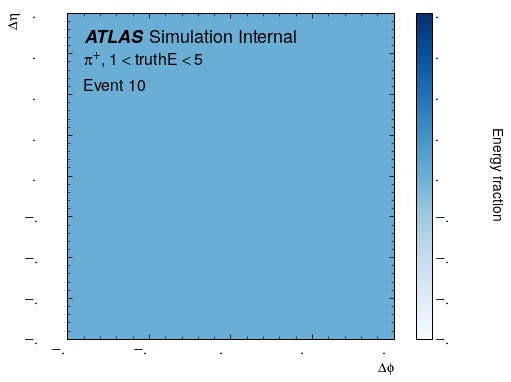

<Figure size 576x432 with 0 Axes>

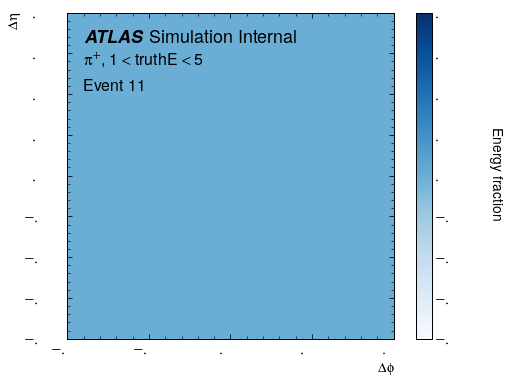

<Figure size 576x432 with 0 Axes>

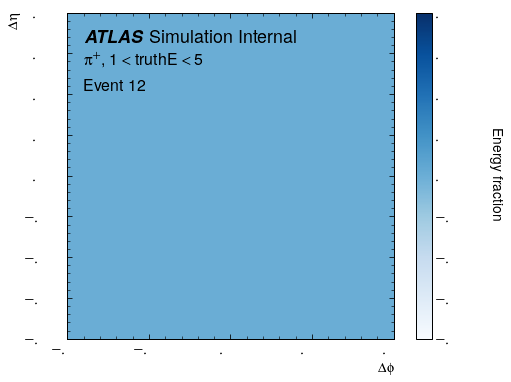

<Figure size 576x432 with 0 Axes>

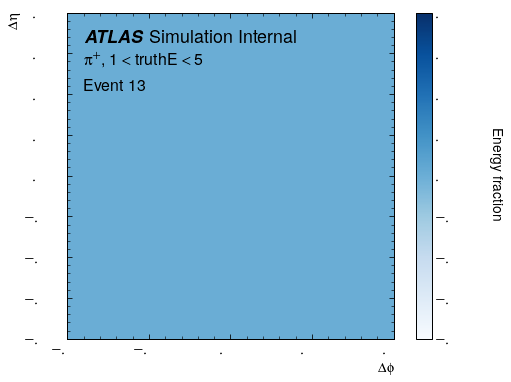

<Figure size 576x432 with 0 Axes>

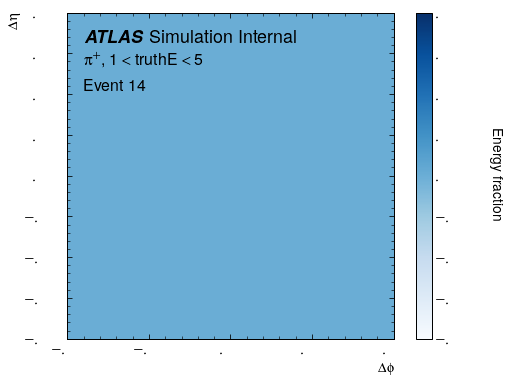

<Figure size 576x432 with 0 Axes>

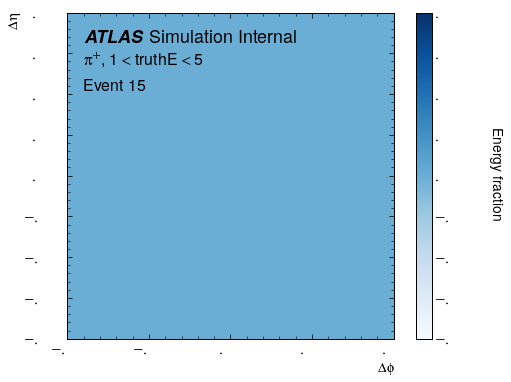

<Figure size 576x432 with 0 Axes>

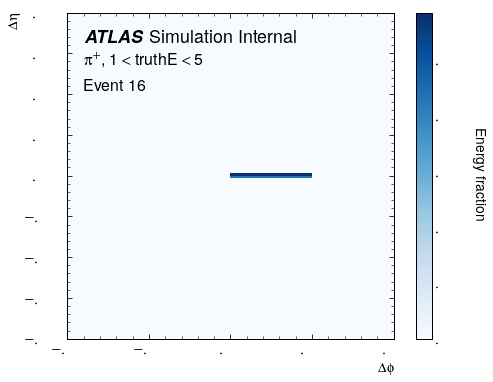

<Figure size 576x432 with 0 Axes>

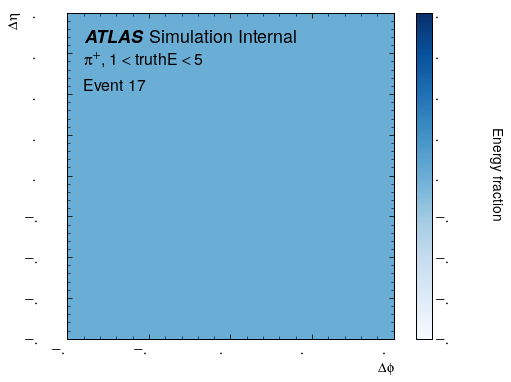

<Figure size 576x432 with 0 Axes>

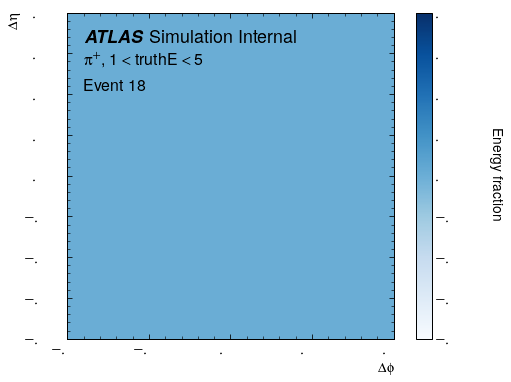

<Figure size 576x432 with 0 Axes>

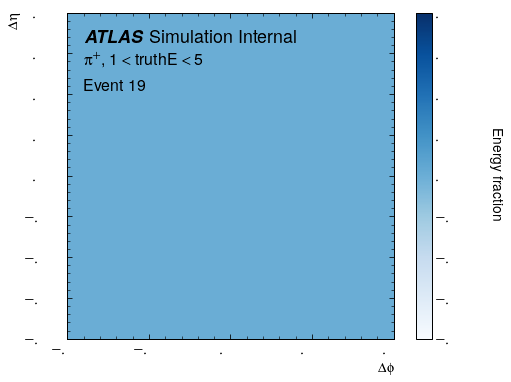

In [23]:
# sel = pdata['pi0']['clusterE'] < 1
sel = (pdata['pi0']['cluster_ENG_CALIB_TOT'] > 5) & (pdata['pi0']['cluster_ENG_CALIB_TOT'] < 50)

for i in range(20):
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.imshow(pcells['pi0']['EMB1'][sel][i], extent=[-0.2, 0.2, -0.2, 0.2],
               cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest')
    ampl.set_xlabel("$\Delta\phi$")
    ampl.set_ylabel("$\Delta\eta$")
    ampl.draw_atlas_label(0.05, 0.95, simulation = True, fontsize = 18)
#     fig.axes[0].text(-0.18, 0.135, '\(\pi^{+}\), clusterE \(<1\)')
    fig.axes[0].text(-0.18, 0.135, '\(\pi^{+}\), \(1<\) truthE \(<5\)')
    fig.axes[0].text(-0.18, 0.105, 'Event '+str(i))
    cbar = plt.colorbar()
    cbar.set_label('Energy fraction', rotation=270, labelpad=20)
#     plt.savefig(plotpath+'individual/'+'nthresh_2000_e1'+'_evt'+str(i)+'.pdf')
    plt.show()

In [63]:
energy_bins = [0,1,5,10,50,100,500,1000]

labels = []
blank_ratio = []
total = []
for i in range(len(energy_bins)):
    blank_ratio.append({})
    if( i == len(energy_bins)-1 ):
        sel = pdata['pi0']['cluster_ENG_CALIB_TOT'] > energy_bins[i]
        label = 'truthE > '+str(energy_bins[i])
    else:
        sel = (pdata['pi0']['cluster_ENG_CALIB_TOT'] > energy_bins[i]) & (pdata['pi0']['cluster_ENG_CALIB_TOT'] < energy_bins[i+1])
        label = str(energy_bins[i])+' < truthE < '+str(energy_bins[i+1])
        
    labels.append(label)
    total.append(len(pcells['pi0'][layer][sel]))
    for layer in mu.cell_meta:
        blank_ratio[i][layer] = len(
            pcells['pi0'][layer][sel][pcells['pi0'][layer][sel].sum(axis=(1,2))==0]
        ) / len(pcells['pi0'][layer][sel]) * 100

In [65]:
print('Percentage of pi0 events with blank images at 2000 MeV noise threshold\n')
print(' {:<20} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8}'.format('','EMB1','EMB2','EMB3','TileBar0','TileBar1','TileBar2','nEvents'))
for i in range(len(energy_bins)):
    entries = ['{:.1f}%'.format(v) for k,v in blank_ratio[i].items()]
    print(' {:<20} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8}'.format(labels[i],*entries,total[i]))

Percentage of pi0 events with blank images at 2000 MeV noise threshold

                      EMB1     EMB2     EMB3     TileBar0 TileBar1 TileBar2 nEvents 
 0 < truthE < 1       100.0%   100.0%   100.0%   100.0%   100.0%   100.0%   41542   
 1 < truthE < 5       99.9%    99.1%    100.0%   99.9%    100.0%   100.0%   56429   
 5 < truthE < 10      98.2%    71.4%    100.0%   99.5%    99.9%    100.0%   22121   
 10 < truthE < 50     49.6%    12.1%    98.8%    96.9%    99.7%    100.0%   43965   
 50 < truthE < 100    5.5%     0.7%     99.4%    99.1%    99.6%    100.0%   18794   
 100 < truthE < 500   1.3%     0.1%     90.1%    98.5%    99.7%    99.9%    43923   
 500 < truthE < 1000  0.5%     0.1%     17.0%    88.5%    99.3%    99.8%    19092   
 truthE > 1000        0.3%     0.0%     0.1%     61.6%    98.8%    99.7%    18301   


In [72]:
sum(total[-3:])/len(pdata['pi0'])

0.3078204317723258